# 1 Problem Definition: Short Term Load Forecasting

Now the prblem includes Temperature as well, as an exogenous variable

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-09-13 13:34:36 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Libraries

In [2]:
#Local Installations
!pip install statsmodels

time: 2.56 s (started: 2024-09-13 13:34:36 +02:00)



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import datetime as dt
import os
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import statsmodels.api as sm
import warnings
import matplotlib.dates as mdates
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

time: 4.28 s (started: 2024-09-13 13:34:38 +02:00)


In [4]:
# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.colors import LogNorm

time: 234 ms (started: 2024-09-13 13:34:43 +02:00)


In [5]:
# ML Algorithms to be used
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR

time: 109 ms (started: 2024-09-13 13:34:43 +02:00)


# 3. Pre-processing


In [6]:
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', 'data')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
def read_Data():
    data_path = os.path.join(RAW_DATA_PATH, "energy.csv") #,parse_dates=[['Date', 'Hour']]) if date and hour to be merged here.
    data = pd.read_csv(data_path)
    return data

time: 0 ns (started: 2024-09-13 13:34:43 +02:00)


In [7]:
data = read_Data()

time: 63 ms (started: 2024-09-13 13:34:43 +02:00)


In [8]:
data = data.dropna()
data.loc[data.Hour == 24, "Hour"] = 0
data.iloc[23]
#Converting time hour into string:
data['Hour']= data['Hour'].apply(str)
#Merging Columns:
data['Date']= data['Date']+' '+ data['Hour']
data = data.drop(['Hour'],axis=1)
# convert the column to datetime type:
datetime_series = pd.to_datetime(data['Date'],format='%d/%m/%Y %H')
#Create datetime index and pass it:
datetime_index = pd.DatetimeIndex(datetime_series.values)
#Updating the indices:
data=(data.set_index(datetime_index)).drop(['Date'],axis=1)
data = data.sort_index()

time: 360 ms (started: 2024-09-13 13:34:43 +02:00)


# SARIMAX : Recursive multi step forecasting with exogenous variables

In [9]:
#Warning update:
#----------------
#each optimization inside the profile likelihood generates a warning, 
#we turn off the warnings here to make the output clean in the below cell:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
#You can check the source code from here:
#https://www.statsmodels.org/0.8.0/_modules/statsmodels/base/model.html

time: 0 ns (started: 2024-09-13 13:34:44 +02:00)


In [10]:
# -------------------------------
# Step 1: Train-Test Split
# -------------------------------
# Define start and end dates for the train and test datasets.
train_start_dt = '2012-09-01'
test_start_dt = '2014-11-01'
test_end_dt = '2014-11-04'

# Split data into training and testing sets based on the defined dates.
# 'load' is the target variable, and 'T' is an exogenous variable (e.g., temperature).
train = data[(data.index >= train_start_dt) & (data.index < test_start_dt)][['load']]
train_temp = data[(data.index >= train_start_dt) & (data.index < test_start_dt)][['T']]
test = data[(data.index >= test_start_dt) & (data.index < test_end_dt)][['load']]
test_temp = data[(data.index >= test_start_dt) & (data.index < test_end_dt)][['T']]

# -------------------------------
# Step 2: Data Preprocessing
# -------------------------------
# Scale the data to the [0,1] range to improve model performance.
scaler_1 = pp.MinMaxScaler()
scaler_2 = pp.MinMaxScaler()

# Fit the scaler on training data and transform both training and test data.
train['load'] = scaler_1.fit_transform(train)
train_temp['T'] = scaler_2.fit_transform(train_temp)
test['load'] = scaler_1.transform(test)
test_temp['T'] = scaler_2.transform(test_temp)

time: 16 ms (started: 2024-09-13 13:34:44 +02:00)


In [11]:
# ------------------------------------------------
# Step 3: Prepare the Data for Time Series Modeling
# ------------------------------------------------
# Set the model's hyperparameters.
horizon = 6  # The number of steps to forecast.
order = (3, 1, 6)  # The (p,d,q) order of the model.
seasonal_order = (1, 1, 1, 24)  # The (P,D,Q,s) seasonal order of the model.

# Prepare the shifted test dataset to include future observations for multi-step forecasting.
test_shifted = test.copy()
for t in range(1, horizon):
    test_shifted[f'load+{t}'] = test_shifted['load'].shift(-t, freq='H')
test_shifted = test_shifted.dropna()  # Drop rows with missing values resulting from the shift operation.

test_shifted

,load,load+1,load+2,load+3,load+4,load+5
2014-11-01 00:00:00,0.223112,0.164869,0.140216,0.126656,0.124191,0.135593
2014-11-01 01:00:00,0.164869,0.140216,0.126656,0.124191,0.135593,0.166718
2014-11-01 02:00:00,0.140216,0.126656,0.124191,0.135593,0.166718,0.226502
2014-11-01 03:00:00,0.126656,0.124191,0.135593,0.166718,0.226502,0.305393
2014-11-01 04:00:00,0.124191,0.135593,0.166718,0.226502,0.305393,0.372881
...,...,...,...,...,...,...
2014-11-03 14:00:00,0.430817,0.427427,0.448382,0.502311,0.585824,0.575655
2014-11-03 15:00:00,0.427427,0.448382,0.502311,0.585824,0.575655,0.539599
2014-11-03 16:00:00,0.448382,0.502311,0.585824,0.575655,0.539599,0.490601
2014-11-03 17:00:00,0.502311,0.585824,0.575655,0.539599,0.490601,0.396302


time: 47 ms (started: 2024-09-13 13:34:44 +02:00)


In [12]:
# Initialize lists to store the historical data and predictions.
history = list(train['load'][-720:])  # Last 720 observations from the training set.
history_Temp = list(train_temp['T'][-720:])  # Matching temperature observations.

# ---------------------------------
# Step 4: Forecasting with SARIMAX
# ---------------------------------

# Initialize the list to store all predictions
predictions = []

# Forecasting loop
for t in range(0, test_shifted.shape[0], horizon):
    # range(0, test_shifted.shape[0], horizon): This part creates a sequence of numbers 
    # starting from 0 up to (but not including) test_shifted.shape[0], which represents 
    # the total number of rows (or data points) in the test_shifted dataset. 
    # The sequence increments by the value of horizon at each step.
    
    # Ensure history and history_Temp have the same length
    min_len = min(len(history), len(history_Temp))
    history = history[-min_len:]
    history_Temp = history_Temp[-min_len:]

    # Fit the SARIMAX model
    model = SARIMAX(endog=history, exog=np.array(history_Temp).reshape(-1, 1), 
                    order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False) # Set 'disp=False' to avoid printing convergence messages

    # Forecast the next 'horizon' steps
    y_p = model_fit.forecast(steps=horizon, 
                             exog=np.array(test_temp['T'].iloc[t:t+horizon]).reshape(-1, 1)).tolist()

    # Store the predictions
    predictions.extend(y_p)  # This line adds the forecasted values to the predictions list

    # Update history lists for the next iteration
    history.extend(y_p)  # Add forecasted values to history for model retraining
    history_Temp.extend(test_temp['T'].iloc[t:t+horizon].tolist())  # Add actual temp values for the forecast period

    # Keep the most recent observations for the next iteration
    history = history[-720:]
    history_Temp = history_Temp[-720:]

    # Optional: Print the forecasted values and their corresponding true values
    print(f"{test_shifted.index[t]}: Predicted = {y_p}, Actual = {test_shifted.iloc[t, :horizon].values.tolist()}")

# Note: Adjust the '720' value according to your specific needs or dataset size.

2014-11-01 00:00:00: Predicted = [0.2055880486712216, 0.1605222514457149, 0.12450701375795162, 0.10175719869002696, 0.1009488727124141, 0.12739208782499947], Actual = [0.22311248073959933, 0.16486902927580893, 0.1402157164869029, 0.12665639445300458, 0.12419106317411399, 0.13559322033898302]
2014-11-01 06:00:00: Predicted = [0.20606257386984514, 0.34126080514332763, 0.4123096495801251, 0.4285470958592197, 0.43767554525704827, 0.43791977007602395], Actual = [0.1667180277349769, 0.22650231124807396, 0.30539291217257314, 0.3728813559322034, 0.42434514637904464, 0.4489984591679508]
2014-11-01 12:00:00: Predicted = [0.4308978338918964, 0.41741296591890686, 0.4098904649007266, 0.39546340949079123, 0.3946892780270246, 0.4135508561420607], Actual = [0.4576271186440677, 0.4499229583975346, 0.44006163328197223, 0.4345146379044684, 0.43852080123266557, 0.4656394453004622]
2014-11-01 18:00:00: Predicted = [0.4509470863865895, 0.48243666870084134, 0.4578968275928206, 0.4201531093604614, 0.350525280

### Key Components Explained:

- Train-Test Split: Divides the dataset into training and testing periods. This separation allows the model to be trained on historical data and tested on unseen future data.
- Data Preprocessing: Scaling the data helps normalize the values, allowing the model to converge more efficiently during training.
- Preparing Data for SARIMAX: Includes setting hyperparameters and preparing future observations for multi-step forecasting.

- Forecasting with SARIMAX:
    - The SARIMAX model is fit to the historical data (history) and exogenous variables (history_Temp).
    - The model makes forecasts for the defined horizon, using the exogenous variables for the same period from the test set.
    - Updates the historical data with the forecasted values, ensuring that the length of the history matches the length of the exogenous variables for accurate future forecasts.
    - This loop continues, making forecasts in chunks of the defined horizon and dynamically updating the historical data used for training.

In [13]:
# Create a DataFrame from the predictions list
# Here, it's crucial to ensure the index matches that of the test set to align predictions with actual values
eval_df = pd.DataFrame(predictions, index=test.index[:len(predictions)])
eval_df.columns = ['prediction']

# Add actual values from the test set to the evaluation DataFrame
# This aligns each prediction with its corresponding actual load value
eval_df['actual'] = test['load'].iloc[:len(predictions)]

# Display the structure and a few example rows of the evaluation DataFrame
print(eval_df.info())
print(eval_df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-11-01 00:00:00 to 2014-11-03 23:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  72 non-null     float64
 1   actual      72 non-null     float64
dtypes: float64(2)
memory usage: 1.7 KB
None
                     prediction    actual
2014-11-01 00:00:00    0.205588  0.223112
2014-11-01 01:00:00    0.160522  0.164869
2014-11-01 02:00:00    0.124507  0.140216
2014-11-01 03:00:00    0.101757  0.126656
2014-11-01 04:00:00    0.100949  0.124191
time: 0 ns (started: 2024-09-13 13:52:18 +02:00)


In [14]:
#Back-transforming:
eval_df[['prediction', 'actual']] = scaler_1.inverse_transform(eval_df[['prediction', 'actual']])

time: 0 ns (started: 2024-09-13 13:52:18 +02:00)


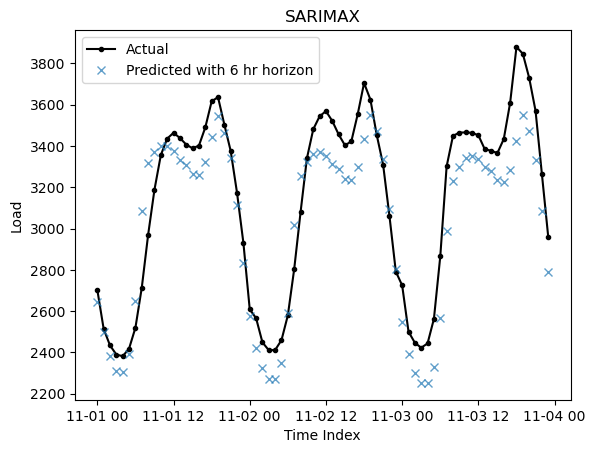

time: 407 ms (started: 2024-09-13 13:52:18 +02:00)


In [15]:
#Plotting predictions: 
plt.figure();
plt.plot(eval_df['actual'], 'k.-');
plt.plot(eval_df['prediction'], 'x', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[69:138], 'o', alpha=0.70);
#plt.plot(np.arange(0, 69),eval_df['prediction'].iloc[-69:], '+', alpha=0.70);
plt.legend(['Actual',
            ('Predicted with ' + str (horizon) + ' hr horizon')])
plt.ylabel('Load');
plt.xlabel('Time Index');
plt.title('SARIMAX');


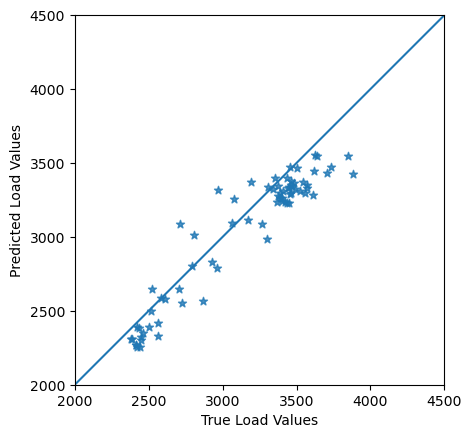

time: 156 ms (started: 2024-09-13 13:52:18 +02:00)


In [16]:
#Visual comparisons of the predictions:
#---------------------------------------
#Visualization of the accuracy
a = plt.axes(aspect='equal')
plt.scatter(eval_df['actual'], eval_df['prediction'],marker='*',alpha=0.80)
#plt.scatter(eval_df['actual'].iloc[0:69], eval_df['prediction'].iloc[69:138],marker='o',alpha=0.60)
#plt.scatter(eval_df['actual'].iloc[0:69], eval_df['prediction'].iloc[138:207],marker='+',alpha=0.50)
plt.xlabel('True Load Values')
plt.ylabel('Predicted Load Values')
lims = [2000, 4500]
plt.xlim(lims), plt.ylim(lims)
plt.plot(lims, lims)

Text(0, 0.5, 'Count')

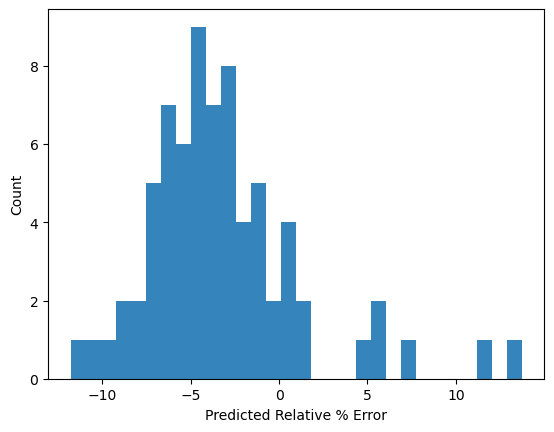

time: 250 ms (started: 2024-09-13 13:52:19 +02:00)


In [17]:
# Calculating the error variations:
error_nn1 = (eval_df['prediction'] - eval_df['actual'])/eval_df['actual']*100

plt.hist(error_nn1, bins=30,alpha=0.9)
plt.xlabel('Predicted Relative % Error')
plt.ylabel('Count')

In [18]:
#Calculating R^2: r2_score(y_true, y_pred)
Score_sarimax = r2_score(eval_df['actual'],eval_df['prediction'])
print('R^2 score is  %3.2f' %np.mean(Score_sarimax))

R^2 score is  0.85
time: 16 ms (started: 2024-09-13 13:52:19 +02:00)
